In [1]:
import pandas as pd
import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
def EmbeddingRec(char_embedding_size, chars_lenght, num_chars, word_embedding_size):
    poll_2_size = int(word_embedding_size / 2)
    poll_3_size = word_embedding_size - poll_2_size
    
    user_input = keras.Input(shape=(1, chars_lenght), name='user_id')
    # embedding
    emb_applied = layers.Embedding(input_dim=num_chars, output_dim=char_embedding_size, name='user_emb')(user_input)

    flatten = keras.layers.Flatten()(emb_applied)
    reshaped = layers.Reshape((chars_lenght, char_embedding_size, 1))(flatten)

    conv_1 = layers.Conv2D(poll_3_size, kernel_size=(3, char_embedding_size), name="conv_1")(reshaped)
    conv_1_flatten = layers.Flatten()(conv_1)
    
    conv_2 = layers.Conv2D(poll_2_size, kernel_size=(2, char_embedding_size), name="conv_2")(reshaped)
    conv_2_flatten = layers.Flatten()(conv_2)
    
    concat = layers.Concatenate()([conv_1_flatten, conv_2_flatten])
    word_embedding = layers.Dense(word_embedding_size, name="result_embedding")(concat)
    # ========
    
    dense_1 = layers.Dense(8, activation='relu', name='FullyConnected-1')(word_embedding)
    
    dense_2 = layers.Dense(8, activation='relu', name='FullyConnected-2')(dense_1)

    result = layers.Dense(word_embedding_size, name='result')(dense_2)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model(user_input, result)
    model.compile(optimizer=adam, loss="mse", metrics="mse")
    
    word_model = keras.Model(user_input, word_embedding)
    
    return model, word_model

In [3]:
model, word_model = EmbeddingRec(
    char_embedding_size=10,
    chars_lenght=3,
    num_chars=10,
    word_embedding_size=2
)

/opt/homebrew/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 3, 10)     100         ['user_id[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 30)           0           ['user_emb[0][0]']               
                                                                                                  
 reshape (Reshape)              (None, 3, 10, 1)     0           ['flatten[0][0]']                
                                                                                              

In [5]:
np.array([[[2, 2, 1]], [[1, 2, 1]]]).shape

(2, 1, 3)

In [6]:
model.predict(np.array([[[2, 2, 1]], [[1, 2, 1]]])).shape

1/1 [==============================] - 0s 66ms/step


2023-04-16 18:27:46.557854: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(2, 2)

In [7]:
model.predict(np.array([[[2, 2, 1]], [[1, 2, 1]]]))

1/1 [==============================] - 0s 8ms/step


array([[-0.0051331 , -0.0043172 ],
       [-0.00330262, -0.00260191]], dtype=float32)

In [8]:
word_model.predict(np.array([[[2, 2, 1]], [[1, 2, 1]]])).shape

1/1 [==============================] - 0s 45ms/step


(2, 2)

In [9]:
word_model.predict(np.array([[[2, 2, 1]], [[1, 2, 1]]]))

1/1 [==============================] - 0s 10ms/step


array([[-0.02304927, -0.07410031],
       [-0.01660324, -0.03741061]], dtype=float32)

In [10]:
word_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 3, 10)     100         ['user_id[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 30)           0           ['user_emb[0][0]']               
                                                                                                  
 reshape (Reshape)              (None, 3, 10, 1)     0           ['flatten[0][0]']                
                                                                                            

In [11]:
def int_to_vec(v):
    p = str(v)
#     if len(p) == 3:
#         z = [int(p[0]), int(p[1]), int(p[2])]
    if len(p) == 2:
        z = [0, int(p[0]), int(p[1])]
    if len(p) == 1:
        z = [0, 0, int(p[0])]
    return z

In [12]:
X = []
y = []

for i in range(100):
    z = int_to_vec(i%100)
    X.append(z)
    z = int_to_vec((i+1)%100)
    y.append(z)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
X_train = np.array(X_train).reshape(len(X_train), 1, 3)
X_test = np.array(X_test).reshape(len(X_test), 1, 3)
y_train = np.array(y_train).reshape(len(y_train), 1, 3)
y_test = np.array(y_test).reshape(len(y_test), 1, 3)

In [20]:
for epoch in range(500):
    model.fit(X_train, word_model.predict(y_train), epochs=1, validation_data=(X_test, word_model.predict(y_test)))
    print("epoch ", epoch)

3/3 [==============================] - 0s 82ms/step - loss: 6.0811e-04 - mse: 6.0811e-04 - val_loss: 6.0919e-04 - val_mse: 6.0919e-04
epoch  0
3/3 [==============================] - 0s 13ms/step - loss: 6.3468e-04 - mse: 6.3468e-04 - val_loss: 5.0384e-04 - val_mse: 5.0384e-04
epoch  1
3/3 [==============================] - 0s 13ms/step - loss: 6.8303e-04 - mse: 6.8303e-04 - val_loss: 4.9820e-04 - val_mse: 4.9820e-04
epoch  2
3/3 [==============================] - 0s 15ms/step - loss: 7.0667e-04 - mse: 7.0667e-04 - val_loss: 5.2834e-04 - val_mse: 5.2834e-04
epoch  3
3/3 [==============================] - 0s 14ms/step - loss: 7.5139e-04 - mse: 7.5139e-04 - val_loss: 5.9550e-04 - val_mse: 5.9550e-04
epoch  4
3/3 [==============================] - 0s 14ms/step - loss: 7.3679e-04 - mse: 7.3679e-04 - val_loss: 6.7517e-04 - val_mse: 6.7517e-04
epoch  5
3/3 [==============================] - 0s 14ms/step - loss: 8.0297e-04 - mse: 8.0297e-04 - val_loss: 7.9119e-04 - val_mse: 7.9119e-04
epoch  6

3/3 [==============================] - 0s 14ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0020 - val_mse: 0.0020
epoch  34
3/3 [==============================] - 0s 14ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0020 - val_mse: 0.0020
epoch  35
3/3 [==============================] - 0s 14ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0019 - val_mse: 0.0019
epoch  36
3/3 [==============================] - 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0019 - val_mse: 0.0019
epoch  37
3/3 [==============================] - 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0019 - val_mse: 0.0019
epoch  38
3/3 [==============================] - 0s 64ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0019 - val_mse: 0.0019
epoch  39
3/3 [==============================] - 0s 13ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0018 - val_mse: 0.0018
epoch  40
3/3 [==============================] - 0s 14ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0018 - va

3/3 [==============================] - 0s 15ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0110 - val_mse: 0.0110
epoch  69
3/3 [==============================] - 0s 13ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0112 - val_mse: 0.0112
epoch  70
3/3 [==============================] - 0s 14ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0114 - val_mse: 0.0114
epoch  71
3/3 [==============================] - 0s 13ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0117 - val_mse: 0.0117
epoch  72
3/3 [==============================] - 0s 13ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0124 - val_mse: 0.0124
epoch  73
3/3 [==============================] - 0s 13ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0127 - val_mse: 0.0127
epoch  74
3/3 [==============================] - 0s 15ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0129 - val_mse: 0.0129
epoch  75
3/3 [==============================] - 0s 15ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0132 - va

3/3 [==============================] - 0s 13ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0208 - val_mse: 0.0208
epoch  104
3/3 [==============================] - 0s 15ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0212
epoch  105
3/3 [==============================] - 0s 14ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0213 - val_mse: 0.0213
epoch  106
3/3 [==============================] - 0s 13ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0213 - val_mse: 0.0213
epoch  107
3/3 [==============================] - 0s 14ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0213 - val_mse: 0.0213
epoch  108
3/3 [==============================] - 0s 13ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0214 - val_mse: 0.0214
epoch  109
3/3 [==============================] - 0s 13ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0214 - val_mse: 0.0214
epoch  110
3/3 [==============================] - 0s 13ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.02

3/3 [==============================] - 0s 14ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0239 - val_mse: 0.0239
epoch  139
3/3 [==============================] - 0s 14ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0239 - val_mse: 0.0239
epoch  140
3/3 [==============================] - 0s 14ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0245 - val_mse: 0.0245
epoch  141
3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0254 - val_mse: 0.0254
epoch  142
3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0257 - val_mse: 0.0257
epoch  143
3/3 [==============================] - 0s 13ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0258 - val_mse: 0.0258
epoch  144
3/3 [==============================] - 0s 13ms/step - loss: 9.9570e-04 - mse: 9.9570e-04 - val_loss: 0.0256 - val_mse: 0.0256
epoch  145
3/3 [==============================] - 0s 14ms/step - loss: 9.2844e-04 - mse: 9.2844e-04 

3/3 [==============================] - 0s 14ms/step - loss: 4.8313e-04 - mse: 4.8313e-04 - val_loss: 0.0411 - val_mse: 0.0411
epoch  173
3/3 [==============================] - 0s 14ms/step - loss: 4.7722e-04 - mse: 4.7722e-04 - val_loss: 0.0414 - val_mse: 0.0414
epoch  174
3/3 [==============================] - 0s 13ms/step - loss: 4.5943e-04 - mse: 4.5943e-04 - val_loss: 0.0418 - val_mse: 0.0418
epoch  175
3/3 [==============================] - 0s 13ms/step - loss: 4.4754e-04 - mse: 4.4754e-04 - val_loss: 0.0425 - val_mse: 0.0425
epoch  176
3/3 [==============================] - 0s 14ms/step - loss: 4.3566e-04 - mse: 4.3566e-04 - val_loss: 0.0429 - val_mse: 0.0429
epoch  177
3/3 [==============================] - 0s 15ms/step - loss: 4.3224e-04 - mse: 4.3224e-04 - val_loss: 0.0433 - val_mse: 0.0433
epoch  178
3/3 [==============================] - 0s 14ms/step - loss: 4.2053e-04 - mse: 4.2053e-04 - val_loss: 0.0433 - val_mse: 0.0433
epoch  179
3/3 [==============================] - 0s

3/3 [==============================] - 0s 13ms/step - loss: 2.3471e-04 - mse: 2.3471e-04 - val_loss: 0.0412 - val_mse: 0.0412
epoch  207
3/3 [==============================] - 0s 14ms/step - loss: 2.3086e-04 - mse: 2.3086e-04 - val_loss: 0.0412 - val_mse: 0.0412
epoch  208
3/3 [==============================] - 0s 13ms/step - loss: 2.2587e-04 - mse: 2.2587e-04 - val_loss: 0.0411 - val_mse: 0.0411
epoch  209
3/3 [==============================] - 0s 13ms/step - loss: 2.2813e-04 - mse: 2.2813e-04 - val_loss: 0.0411 - val_mse: 0.0411
epoch  210
3/3 [==============================] - 0s 14ms/step - loss: 2.1801e-04 - mse: 2.1801e-04 - val_loss: 0.0409 - val_mse: 0.0409
epoch  211
3/3 [==============================] - 0s 13ms/step - loss: 2.1686e-04 - mse: 2.1686e-04 - val_loss: 0.0408 - val_mse: 0.0408
epoch  212
3/3 [==============================] - 0s 15ms/step - loss: 2.0687e-04 - mse: 2.0687e-04 - val_loss: 0.0409 - val_mse: 0.0409
epoch  213
3/3 [==============================] - 0s

3/3 [==============================] - 0s 14ms/step - loss: 1.1333e-04 - mse: 1.1333e-04 - val_loss: 0.0417 - val_mse: 0.0417
epoch  241
3/3 [==============================] - 0s 13ms/step - loss: 1.1127e-04 - mse: 1.1127e-04 - val_loss: 0.0420 - val_mse: 0.0420
epoch  242
3/3 [==============================] - 0s 13ms/step - loss: 1.0785e-04 - mse: 1.0785e-04 - val_loss: 0.0422 - val_mse: 0.0422
epoch  243
3/3 [==============================] - 0s 15ms/step - loss: 1.0382e-04 - mse: 1.0382e-04 - val_loss: 0.0424 - val_mse: 0.0424
epoch  244
3/3 [==============================] - 0s 14ms/step - loss: 1.0322e-04 - mse: 1.0322e-04 - val_loss: 0.0427 - val_mse: 0.0427
epoch  245
3/3 [==============================] - 0s 14ms/step - loss: 1.0014e-04 - mse: 1.0014e-04 - val_loss: 0.0430 - val_mse: 0.0430
epoch  246
3/3 [==============================] - 0s 14ms/step - loss: 9.9331e-05 - mse: 9.9331e-05 - val_loss: 0.0431 - val_mse: 0.0431
epoch  247
3/3 [==============================] - 0s

3/3 [==============================] - 0s 14ms/step - loss: 1.0100e-04 - mse: 1.0100e-04 - val_loss: 0.0443 - val_mse: 0.0443
epoch  275
3/3 [==============================] - 0s 13ms/step - loss: 1.0068e-04 - mse: 1.0068e-04 - val_loss: 0.0439 - val_mse: 0.0439
epoch  276
3/3 [==============================] - 0s 15ms/step - loss: 9.8332e-05 - mse: 9.8332e-05 - val_loss: 0.0437 - val_mse: 0.0437
epoch  277
3/3 [==============================] - 0s 14ms/step - loss: 9.6939e-05 - mse: 9.6939e-05 - val_loss: 0.0435 - val_mse: 0.0435
epoch  278
3/3 [==============================] - 0s 14ms/step - loss: 9.6767e-05 - mse: 9.6767e-05 - val_loss: 0.0435 - val_mse: 0.0435
epoch  279
3/3 [==============================] - 0s 15ms/step - loss: 9.0755e-05 - mse: 9.0755e-05 - val_loss: 0.0434 - val_mse: 0.0434
epoch  280
3/3 [==============================] - 0s 13ms/step - loss: 9.3110e-05 - mse: 9.3110e-05 - val_loss: 0.0431 - val_mse: 0.0431
epoch  281
3/3 [==============================] - 0s

3/3 [==============================] - 0s 15ms/step - loss: 6.8280e-05 - mse: 6.8280e-05 - val_loss: 0.0413 - val_mse: 0.0413
epoch  309
3/3 [==============================] - 0s 14ms/step - loss: 6.7741e-05 - mse: 6.7741e-05 - val_loss: 0.0415 - val_mse: 0.0415
epoch  310
3/3 [==============================] - 0s 15ms/step - loss: 6.7055e-05 - mse: 6.7055e-05 - val_loss: 0.0416 - val_mse: 0.0416
epoch  311
3/3 [==============================] - 0s 14ms/step - loss: 6.4981e-05 - mse: 6.4981e-05 - val_loss: 0.0418 - val_mse: 0.0418
epoch  312
3/3 [==============================] - 0s 14ms/step - loss: 6.2895e-05 - mse: 6.2895e-05 - val_loss: 0.0419 - val_mse: 0.0419
epoch  313
3/3 [==============================] - 0s 14ms/step - loss: 6.1425e-05 - mse: 6.1425e-05 - val_loss: 0.0422 - val_mse: 0.0422
epoch  314
3/3 [==============================] - 0s 14ms/step - loss: 6.0608e-05 - mse: 6.0608e-05 - val_loss: 0.0422 - val_mse: 0.0422
epoch  315
3/3 [==============================] - 0s

3/3 [==============================] - 0s 14ms/step - loss: 6.1615e-05 - mse: 6.1615e-05 - val_loss: 0.0432 - val_mse: 0.0432
epoch  343
3/3 [==============================] - 0s 14ms/step - loss: 5.8974e-05 - mse: 5.8974e-05 - val_loss: 0.0431 - val_mse: 0.0431
epoch  344
3/3 [==============================] - 0s 14ms/step - loss: 5.7817e-05 - mse: 5.7817e-05 - val_loss: 0.0430 - val_mse: 0.0430
epoch  345
3/3 [==============================] - 0s 13ms/step - loss: 5.6912e-05 - mse: 5.6912e-05 - val_loss: 0.0429 - val_mse: 0.0429
epoch  346
3/3 [==============================] - 0s 67ms/step - loss: 5.6707e-05 - mse: 5.6707e-05 - val_loss: 0.0429 - val_mse: 0.0429
epoch  347
3/3 [==============================] - 0s 13ms/step - loss: 5.4562e-05 - mse: 5.4562e-05 - val_loss: 0.0427 - val_mse: 0.0427
epoch  348
3/3 [==============================] - 0s 14ms/step - loss: 5.6354e-05 - mse: 5.6354e-05 - val_loss: 0.0426 - val_mse: 0.0426
epoch  349
3/3 [==============================] - 0s

3/3 [==============================] - 0s 13ms/step - loss: 4.3063e-05 - mse: 4.3063e-05 - val_loss: 0.0422 - val_mse: 0.0422
epoch  377
3/3 [==============================] - 0s 15ms/step - loss: 4.3477e-05 - mse: 4.3477e-05 - val_loss: 0.0423 - val_mse: 0.0423
epoch  378
3/3 [==============================] - 0s 14ms/step - loss: 4.3301e-05 - mse: 4.3301e-05 - val_loss: 0.0424 - val_mse: 0.0424
epoch  379
3/3 [==============================] - 0s 14ms/step - loss: 4.4954e-05 - mse: 4.4954e-05 - val_loss: 0.0426 - val_mse: 0.0426
epoch  380
3/3 [==============================] - 0s 14ms/step - loss: 4.5360e-05 - mse: 4.5360e-05 - val_loss: 0.0428 - val_mse: 0.0428
epoch  381
3/3 [==============================] - 0s 14ms/step - loss: 4.4809e-05 - mse: 4.4809e-05 - val_loss: 0.0429 - val_mse: 0.0429
epoch  382
3/3 [==============================] - 0s 15ms/step - loss: 4.6049e-05 - mse: 4.6049e-05 - val_loss: 0.0431 - val_mse: 0.0431
epoch  383
3/3 [==============================] - 0s

3/3 [==============================] - 0s 13ms/step - loss: 4.2051e-05 - mse: 4.2051e-05 - val_loss: 0.0421 - val_mse: 0.0421
epoch  411
3/3 [==============================] - 0s 13ms/step - loss: 4.2415e-05 - mse: 4.2415e-05 - val_loss: 0.0419 - val_mse: 0.0419
epoch  412
3/3 [==============================] - 0s 14ms/step - loss: 4.0945e-05 - mse: 4.0945e-05 - val_loss: 0.0418 - val_mse: 0.0418
epoch  413
3/3 [==============================] - 0s 13ms/step - loss: 4.1968e-05 - mse: 4.1968e-05 - val_loss: 0.0417 - val_mse: 0.0417
epoch  414
3/3 [==============================] - 0s 13ms/step - loss: 4.1605e-05 - mse: 4.1605e-05 - val_loss: 0.0417 - val_mse: 0.0417
epoch  415
3/3 [==============================] - 0s 13ms/step - loss: 4.1462e-05 - mse: 4.1462e-05 - val_loss: 0.0415 - val_mse: 0.0415
epoch  416
3/3 [==============================] - 0s 14ms/step - loss: 4.1815e-05 - mse: 4.1815e-05 - val_loss: 0.0414 - val_mse: 0.0414
epoch  417
3/3 [==============================] - 0s

3/3 [==============================] - 0s 15ms/step - loss: 4.8818e-05 - mse: 4.8818e-05 - val_loss: 0.0423 - val_mse: 0.0423
epoch  445
3/3 [==============================] - 0s 14ms/step - loss: 4.7841e-05 - mse: 4.7841e-05 - val_loss: 0.0425 - val_mse: 0.0425
epoch  446
3/3 [==============================] - 0s 15ms/step - loss: 4.5916e-05 - mse: 4.5916e-05 - val_loss: 0.0427 - val_mse: 0.0427
epoch  447
3/3 [==============================] - 0s 13ms/step - loss: 4.6853e-05 - mse: 4.6853e-05 - val_loss: 0.0424 - val_mse: 0.0424
epoch  448
3/3 [==============================] - 0s 14ms/step - loss: 4.5464e-05 - mse: 4.5464e-05 - val_loss: 0.0426 - val_mse: 0.0426
epoch  449
3/3 [==============================] - 0s 14ms/step - loss: 4.6419e-05 - mse: 4.6419e-05 - val_loss: 0.0427 - val_mse: 0.0427
epoch  450
3/3 [==============================] - 0s 13ms/step - loss: 5.0265e-05 - mse: 5.0265e-05 - val_loss: 0.0426 - val_mse: 0.0426
epoch  451
3/3 [==============================] - 0s

3/3 [==============================] - 0s 13ms/step - loss: 3.5971e-05 - mse: 3.5971e-05 - val_loss: 0.0406 - val_mse: 0.0406
epoch  479
3/3 [==============================] - 0s 14ms/step - loss: 3.3109e-05 - mse: 3.3109e-05 - val_loss: 0.0406 - val_mse: 0.0406
epoch  480
3/3 [==============================] - 0s 13ms/step - loss: 3.5251e-05 - mse: 3.5251e-05 - val_loss: 0.0409 - val_mse: 0.0409
epoch  481
3/3 [==============================] - 0s 13ms/step - loss: 3.4634e-05 - mse: 3.4634e-05 - val_loss: 0.0408 - val_mse: 0.0408
epoch  482
3/3 [==============================] - 0s 13ms/step - loss: 3.3862e-05 - mse: 3.3862e-05 - val_loss: 0.0408 - val_mse: 0.0408
epoch  483
3/3 [==============================] - 0s 12ms/step - loss: 3.2934e-05 - mse: 3.2934e-05 - val_loss: 0.0410 - val_mse: 0.0410
epoch  484
3/3 [==============================] - 0s 13ms/step - loss: 3.3046e-05 - mse: 3.3046e-05 - val_loss: 0.0410 - val_mse: 0.0410
epoch  485
3/3 [==============================] - 0s

In [21]:
model.predict([0, 1, 6])

1/1 [==============================] - 0s 57ms/step


array([[-0.6087272 , -0.47567257]], dtype=float32)

In [22]:
model.predict([0, 1, 7])

1/1 [==============================] - 0s 21ms/step


array([[-0.5954726 , -0.46618104]], dtype=float32)

In [23]:
word_model.predict([0, 1, 7])

1/1 [==============================] - 0s 39ms/step


array([[-0.61291856, -0.4773172 ]], dtype=float32)

In [24]:
word_model.predict([0, 1, 8])

1/1 [==============================] - 0s 17ms/step


array([[-0.59835273, -0.46676207]], dtype=float32)

In [25]:
word_model.predict([[4, 5, 5], [3, 4, 2], [3, 4, 3]])

1/1 [==============================] - 0s 21ms/step


array([[0.37192297, 0.35504273],
       [0.10656652, 0.084631  ],
       [0.12387344, 0.09294626]], dtype=float32)

1/1 [==============================] - 0s 15ms/step


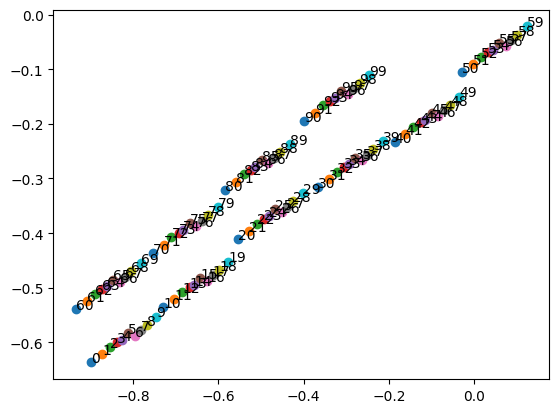

In [26]:
import random

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(100):
    pred = word_model.predict([int_to_vec(i)])
    ax.scatter(pred[:,0], pred[:,1])
    ax.annotate(i, pred[0])

In [27]:
for i in range(100):
    pred = word_model.predict([int_to_vec(i)])
    print(i, pred)

1/1 [==============================] - 0s 15ms/step
0 [[-0.8979633 -0.6367113]]
1/1 [==============================] - 0s 15ms/step
1 [[-0.87244135 -0.6219756 ]]
1/1 [==============================] - 0s 14ms/step
2 [[-0.853973  -0.6081994]]
1/1 [==============================] - 0s 14ms/step
3 [[-0.83666617 -0.59988415]]
1/1 [==============================] - 0s 14ms/step
4 [[-0.82610464 -0.59488267]]
1/1 [==============================] - 0s 14ms/step
5 [[-0.8112927 -0.5823938]]
1/1 [==============================] - 0s 14ms/step
6 [[-0.7955297  -0.58751386]]
1/1 [==============================] - 0s 16ms/step
7 [[-0.7822824 -0.5780001]]
1/1 [==============================] - 0s 14ms/step
8 [[-0.7677167 -0.567445 ]]
1/1 [==============================] - 0s 14ms/step
9 [[-0.74586916 -0.55260557]]
1/1 [==============================] - 0s 14ms/step
10 [[-0.7285993  -0.53602844]]
1/1 [==============================] - 0s 14ms/step
11 [[-0.7030773 -0.5212927]]
1/1 [=====================

1/1 [==============================] - 0s 14ms/step
99 [[-0.24668731 -0.11068204]]


In [28]:
model.predict(np.array([[[9, 0, 0]]]))

1/1 [==============================] - 0s 7ms/step


array([[-0.5807584 , -0.31889275]], dtype=float32)

In [29]:
word_model.predict(np.array([[[9, 0, 1]]]))

1/1 [==============================] - 0s 8ms/step


array([[-0.5729939, -0.3152435]], dtype=float32)